In [53]:
import pandas as pd
import numpy as np

from scipy.stats import poisson,gamma,norm,lognorm
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt
import statsmodels.api as sm
import altair as alt
import seaborn as sns

In [57]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df = data.copy()
df.head()
df["DEATH_EVENT"] = df["DEATH_EVENT"].replace({0: "Survival", 1: "Death"})
df["sex"] = df["sex"].replace({0: "Female", 1: "Male"})
df["anaemia"] = df["anaemia"].replace({0: "False", 1: "True"})
df["high_blood_pressure"] = df["high_blood_pressure"].replace({0: "False", 1: "True"})
df["diabetes"] = df["diabetes"].replace({0: "False", 1: "True"})
df["smoking"] = df["smoking"].replace({0: "False", 1: "True"})
# y = df["DEATH_EVENT"].factorize()[0]
# pie_plot = y.value_counts().reset_index().rename(columns={"index": "categories", 0: "value"})
# y = pd.Series(y)
# pie_plot = y.value_counts().reset_index().rename(columns={"index": "categories", 0: "value"})
# pie_plot['categories'] = pie_plot['categories'].map({0: "Death", 1: "Survival"})

## Statistic Description

In [3]:
df["DEATH_EVENT"].value_counts()

Survival    203
Death        96
Name: DEATH_EVENT, dtype: int64

In [8]:
origin = df[quantitative_columns].agg(['mean', 'median', 'var']).T
origin
stacked_df = origin.stack().to_frame()
stacked_df
# Rename the column
stacked_df.columns = ['overall']
stacked_df
groups = df[quantitative_columns].groupby(df["DEATH_EVENT"]).agg(['mean', 'var', 'median']).T
groups
summary = pd.concat([groups,stacked_df],axis=1)
rounded_df = summary.round(2)
rounded_df

Death      Survival       overall
age                      mean    6.522000e+01  5.876000e+01  6.083000e+01
                         var     1.746200e+02  1.131600e+02  1.414900e+02
                         median  6.500000e+01  6.000000e+01  6.000000e+01
creatinine_phosphokinase mean    6.702000e+02  5.400500e+02  5.818400e+02
                         var     1.733385e+06  5.682138e+05  9.414586e+05
                         median  2.590000e+02  2.450000e+02  2.500000e+02
ejection_fraction        mean    3.347000e+01  4.027000e+01  3.808000e+01
                         var     1.568800e+02  1.179400e+02  1.400600e+02
                         median  3.000000e+01  3.800000e+01  3.800000e+01
platelets                mean    2.563810e+05  2.666575e+05  2.633580e+05
                         var     9.707310e+09  9.512335e+09  9.565669e+09
                         median  2.585000e+05  2.630000e+05  2.620000e+05
serum_creatinine         mean    1.840000e+00  1.180000e+00  1.390000e+00
                         var     2.160000e+00  4.300000e-01  1.070000e+00
                         median  1.300000e+00  1.000000e+00  1.100000e+00
serum_sodium             mean    1.353800e+02  1.372200e+02  1.366300e+02
                         var     2.502000e+01  1.586000e+01  1.947000e+01
                         median  1.355000e+02  1.370000e+02  1.370000e+02
time                     mean    7.089000e+01  1.583400e+02  1.302600e+02
                         var     3.891050e+03  4.589100e+03  6.023970e+03
                         median  4.450000e+01  1.720000e+02  1.150000e+02

## Visualization

### Target value


In [4]:
alt.Chart(df).mark_arc().encode(theta="count(DEATH_EVENT)",color="DEATH_EVENT:N",)


alt.Chart(...)

In [5]:
quantitative_columns = ['age', 'creatinine_phosphokinase','ejection_fraction',  'platelets',
       'serum_creatinine', 'serum_sodium',  'time']
qualitative_columns = set(df.columns)-set(quantitative_columns)-set(["DEATH_EVENT"])
qualitative_columns = list(qualitative_columns)

### categorical variables

In [6]:
alt.Chart(df).mark_rect().encode(
    y=alt.Y('DEATH_EVENT:N',title=None),
    x=alt.X(alt.repeat("column"), type='nominal'),
    color='count(DEATH_EVENT):Q'
).properties(
    width=100,
    height=100
).repeat(column=qualitative_columns)


alt.RepeatChart(...)

### numeric variables

In [16]:
from sklearn.neighbors import KernelDensity
sigma_hat = np.std(df['time'])
n = len(df['time'])
h_hat = 1.06 * sigma_hat * n**-0.2
kde = KernelDensity(kernel='gaussian', bandwidth=h_hat).fit(np.array(df['time']).reshape(-1,1))
xr = np.linspace(df["time"].min(), df["time"].max(), 200).reshape(-1,1)
# KerndelDensity.score_samples returns log-likelihood,not density.
p = np.exp(kde.score_samples(xr))

In [7]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2)
gm.fit(np.array(df["time"]).reshape(-1,1))
xr = np.linspace(df["time"].min(), df["time"].max(), 200).reshape(-1,1)
density = np.exp(gm.score_samples(xr))
density

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([0.0013267 , 0.0014058 , 0.00148787, 0.0015729 , 0.00166086,
       0.0017517 , 0.00184535, 0.00194175, 0.0020408 , 0.00214241,
       0.00224646, 0.00235283, 0.00246136, 0.00257189, 0.00268427,
       0.00279829, 0.00291376, 0.00303047, 0.00314818, 0.00326665,
       0.00338564, 0.00350488, 0.00362409, 0.003743  , 0.00386131,
       0.00397872, 0.00409493, 0.00420962, 0.00432249, 0.00443323,
       0.0045415 , 0.00464701, 0.00474943, 0.00484846, 0.00494379,
       0.00503514, 0.0051222 , 0.0052047 , 0.00528238, 0.00535497,
       0.00542225, 0.00548399, 0.00553998, 0.00559003, 0.00563397,
       0.00567166, 0.00570296, 0.00572777, 0.005746  , 0.0057576 ,
       0.00576252, 0.00576076, 0.00575232, 0.00573724, 0.00571557,
       0.0056874 , 0.00565283, 0.005612  , 0.00556504, 0.00551214,
       0.00545348, 0.00538928, 0.00531976, 0.00524519, 0.00516582,
       0.00508193, 0.00499383, 0.00490182, 0.00480622, 0.00470737,
       0.0046056 , 0.00450126, 0.00439472, 0.00428633, 0.00417

In [36]:
platelets_ps

(263358.02926421404, 97640.54765451424)

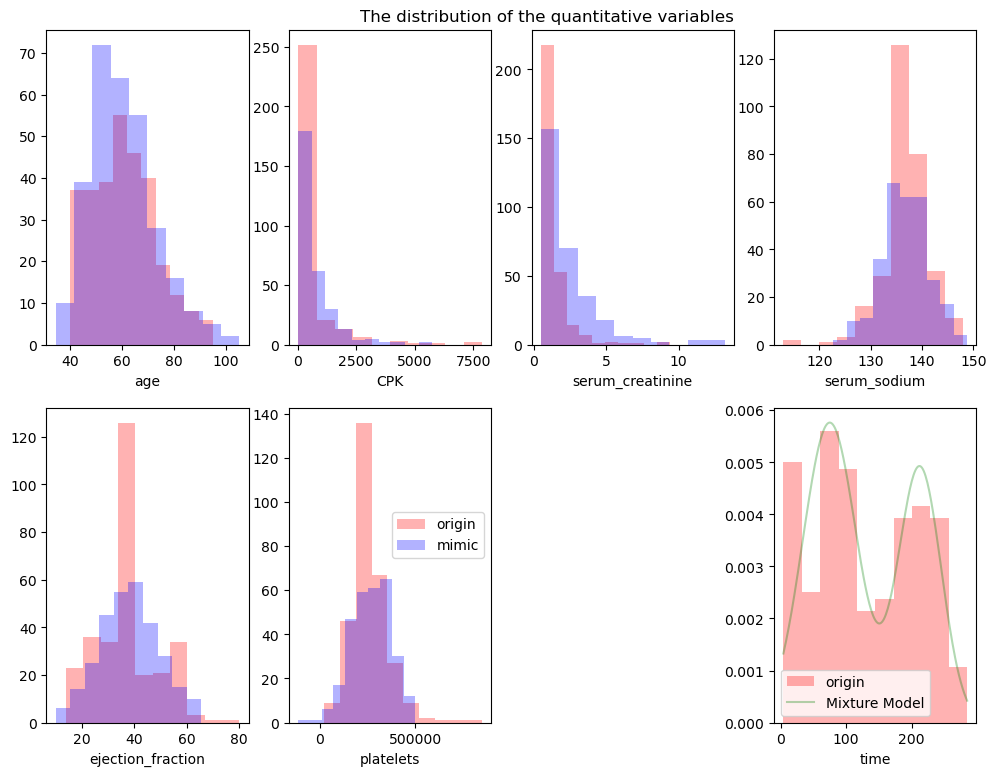

In [28]:
N = 299
fig = plt.figure(figsize=(12, 9))

plt.subplot(2,4,1)
age_ps = gamma.fit(df["age"])
age = gamma(*age_ps).rvs(N)
plt.hist(df["age"],color="red",label="origin",alpha=0.3)
plt.hist(age,color="blue",label="mimic",alpha=0.3)
plt.xlabel("age")

plt.subplot(2,4,2)
cpk_ps = gamma.fit(df["creatinine_phosphokinase"])
cpk = gamma(*cpk_ps).rvs(N)
plt.hist(df["creatinine_phosphokinase"],color="red",label="origin",alpha=0.3)
plt.hist(cpk,color="blue",label="mimic",alpha=0.3)
plt.xlabel("CPK")

plt.subplot(2,4,5)
ej_ps = norm.fit(df["ejection_fraction"])
ej = norm(*ej_ps).rvs(N)
plt.hist(df["ejection_fraction"],color="red",label="origin",alpha=0.3)
plt.hist(ej,color="blue",label="mimic",alpha=0.3)
plt.xlabel("ejection_fraction")


plt.subplot(2,4,6)
platelets_ps = norm.fit(df["platelets"])
platelets = norm(*platelets_ps).rvs(N)
# can not be assume as normal but other one is more weired
plt.hist(df["platelets"],color="red",label="origin",alpha=0.3)
plt.hist(platelets,color="blue",label="mimic",alpha=0.3)
plt.xlabel("platelets")
plt.legend(loc="lower right",bbox_to_anchor=(1, 0.5))

plt.subplot(2,4,3)
sc_ps = gamma.fit(df["serum_creatinine"])
sc = gamma(*sc_ps).rvs(N)
plt.hist(df["serum_creatinine"],color="red",label="origin",alpha=0.3)
plt.hist(sc,color="blue",label="mimic",alpha=0.3)
plt.xlabel("serum_creatinine")
plt.title("The distribution of the quantitative variables",loc="right")

plt.subplot(2,4,4)
ss_ps = gamma.fit(df["serum_sodium"])
ss = gamma(*ss_ps).rvs(N)
plt.hist(df["serum_sodium"],color="red",label="origin",alpha=0.3)
plt.hist(ss,color="blue",label="mimic",alpha=0.3)
plt.xlabel("serum_sodium")




plt.subplot(2,4,8)
# time_ps = gamma.fit(df["time"])
# time = gamma(*time_ps).rvs(N)
plt.hist(df["time"],color="red",label="origin",alpha=0.3,density=True)
plt.plot(xr,density,color="green",alpha=0.3,label="Mixture Model")
# plt.plot(xr,p,color="green",alpha=0.3,label="Kernel")
plt.legend()
plt.xlabel("time")


plt.show()

### Correlation Matrix

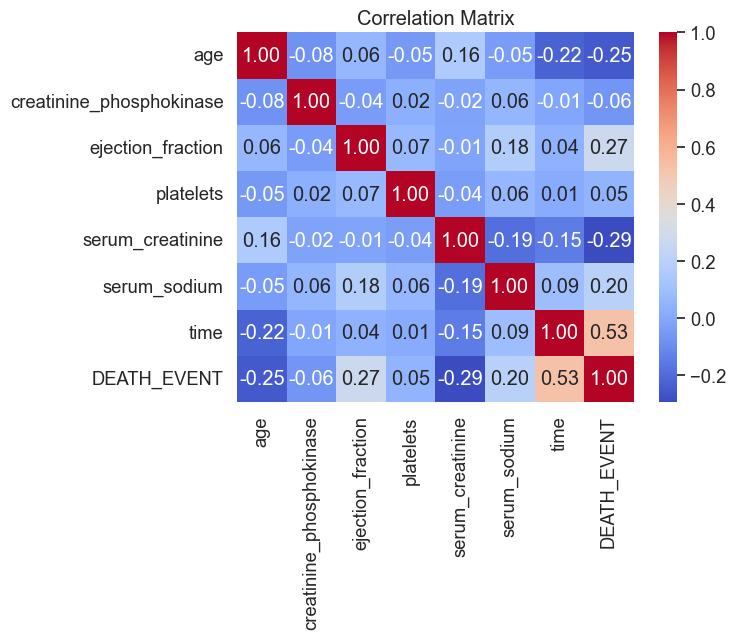

In [24]:
corr = quantitative_columns+["DEATH_EVENT"]
df["DEATH_EVENT"] = df["DEATH_EVENT"].factorize()[0]
corr_matrix = np.corrcoef(df[corr], rowvar=False)
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=corr, yticklabels=corr)
plt.title('Correlation Matrix')
plt.show()

In [10]:
# row1 = alt.Chart(df).mark_bar().encode(x=alt.X(alt.repeat("column"), bin=alt.Bin(maxbins=20), type='quantitative'),y="count()").repeat(column=quantitative_columns[:3])
# row2 = alt.Chart(df).mark_bar().encode(x=alt.X(alt.repeat("column"), bin=alt.Bin(maxbins=20), type='quantitative'),y="count()").repeat(column=quantitative_columns[3:])
# row1 & row2
# # row1

In [17]:
# box1 = alt.Chart(df).mark_boxplot().encode(y=alt.Y(alt.repeat("column"),type='quantitative'),x=alt.X("DEATH_EVENT",type='nominal')).repeat(column=quantitative_columns[:3])
# box2 = alt.Chart(df).mark_boxplot().encode(y=alt.Y(alt.repeat("column"),type='quantitative'),x=alt.X("DEATH_EVENT",type='nominal')).repeat(column=quantitative_columns[3:])
# box1 & box2
# # row1

In [18]:
# point1 = alt.Chart(df).mark_circle().encode(x=alt.X(alt.repeat("column"),type='quantitative'),y=alt.Y("time",type='quantitative')).repeat(column=quantitative_columns[:3])
# point2 = alt.Chart(df).mark_circle().encode(x=alt.X(alt.repeat("column"),type='quantitative'),y=alt.Y("time",type='quantitative')).repeat(column=quantitative_columns[3:6])
# point1 & point2
# # row1

## Data Preprocessing

### OverSampling

In [58]:
oversample = RandomOverSampler()
y = data["DEATH_EVENT"].factorize()[0]
data.drop(columns=["DEATH_EVENT"],inplace=True)
X,Y = oversample.fit_resample(data,y)
np.count_nonzero(y)/len(y)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

### Standardization

In [59]:
scaler = StandardScaler()
x_train_scaled  = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Feature selection

### Z-score

In [42]:
df_columns

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time']

In [67]:
df_columns = list(data.columns)
z = {}
for i in df_columns:
    u0,sigma0 = norm.fit(data.loc[y==0,i])
    u1,sigma1 = norm.fit(data.loc[y==1,i])
    z[i] = np.abs((u0-u1))/np.sqrt(np.abs(sigma0**2-sigma1**2))
Z = pd.Series(z)
Z.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5976\53856918.py:6: RuntimeWarning: invalid value encountered in sqrt
  z[i] = (u0-u1)/np.sqrt(sigma0**2-sigma1**2)


## Models

### Logistic Regression

lr = LogisticRegression(max_iter=1000,multi_class='ovr')
lr.fit(x_train_scaled,y_train)
y_pred = lr.predict(x_test_scaled)
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot()
print("The accuracy is {}".format(accuracy_score(y_test,y_pred)))
lr.coef_

### RandomForest

The accuracy is 0.9390243902439024


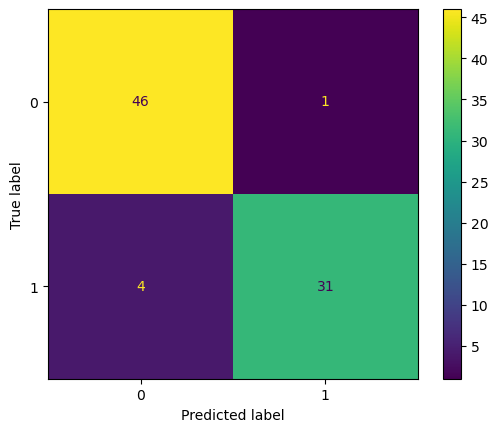

In [33]:

rf = RandomForestClassifier()
rf.fit(x_train_scaled,y_train)
y_pred = rf.predict(x_test_scaled)
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot()
print("The accuracy is {}".format(accuracy_score(y_test,y_pred)))

<Axes: >

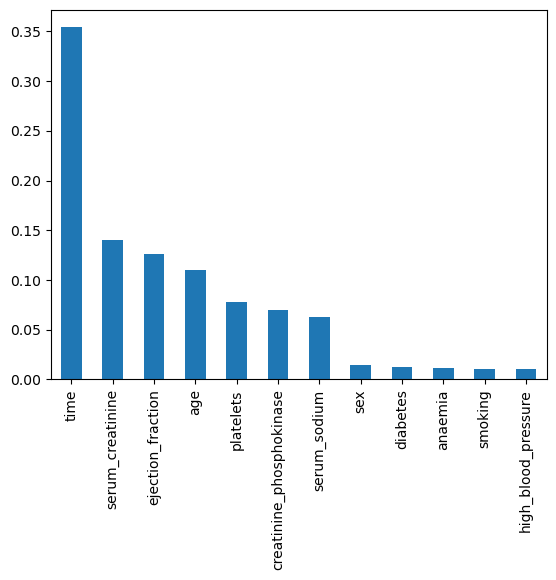

In [47]:
feature_importances = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()

### Trees

The accurancy of test data is 0.8780487804878049
0.8458173076923077


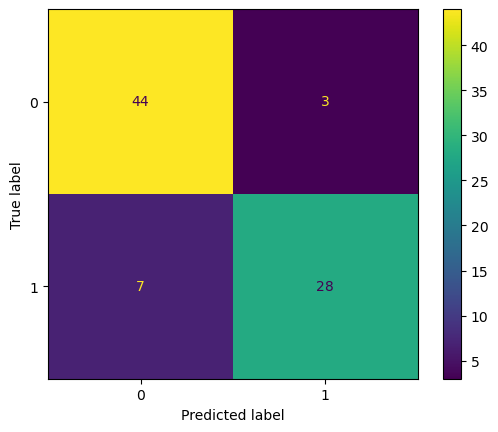

In [35]:
TREE=DecisionTreeClassifier()
TREE.fit(x_train_scaled,y_train)
y_pred_test=TREE.predict(x_test_scaled)
cm = confusion_matrix(y_test,y_pred_test)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot()
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(cross_val_score(TREE,x_train,y_train).mean())

In [36]:
# a=raw_data["Grade"].copy()
# a=a.map({0:'low',1:'medium',2:'high'}).unique().tolist()
# plt.figure(figsize=(15, 10))
# plot_tree(model_TREE, filled=True, feature_names=raw_x.columns.tolist(),class_names=a,rounded=True)
# plt.savefig('decision_tree.png') 
# plt.show()

NameError: name 'raw_data' is not defined

### Boosting